In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys
import soundfile
import os, glob, pickle

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [ ]:
ravedess = '/content/drive/MyDrive/ds_dataset'

In [ ]:
# ravedess = '/content/drive/MyDrive/Colab Notebooks/ds_dataset'

In [ ]:
# Set the directory path where the audio files are stored
dir_path = ravedess
# Initialize an empty list to store the audio data
r_audio_data = []

# Loop through all the audio files in the directory
for file in os.listdir(dir_path):
    # Load the audio file using librosa
    audio, sr = librosa.load(os.path.join(dir_path, file))
    
    # Append the audio data to the list
    r_audio_data.append(audio)


paths = []
labels = []
for dirname, _, filenames in os.walk(ravedess):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 1440:
         break
# print(labels)
print('Dataset is Loaded')

df= pd.DataFrame()
df['speech']= paths
df['emotion']= labels

df['label_name']=df['emotion'].apply(lambda x: x[7])
df
df['label_name']=df['label_name'].map({'1':'Neutral','2':'Calm','3':'Happy','4':'Sad','5':'Angry','6':'Fearful','7':'Disgust','8':'Surprised'})

Dataset is Loaded


In [ ]:
df.head(5)

,speech,emotion,label_name
0,/content/drive/MyDrive/ds_dataset/03-01-03-02-...,03-01-03-02-02-01-08,Happy
1,/content/drive/MyDrive/ds_dataset/03-01-02-01-...,03-01-02-01-02-02-08,Calm
2,/content/drive/MyDrive/ds_dataset/03-01-02-02-...,03-01-02-02-01-02-08,Calm
3,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-02-01-08,Happy
4,/content/drive/MyDrive/ds_dataset/03-01-04-02-...,03-01-04-02-01-01-08,Sad


In [ ]:
print(df['label_name'].value_counts())

Happy        192
Calm         192
Sad          192
Angry        192
Fearful      192
Disgust      192
Surprised    192
Neutral       96
Name: label_name, dtype: int64


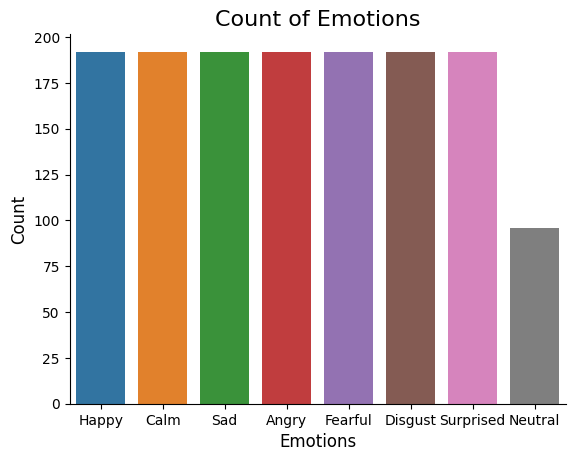

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=df, x='label_name')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
df.drop(df[df['label_name'] == 'Neutral'].index, inplace = True)

In [ ]:
df.drop(df[df['label_name'] == 'Disgust'].index, inplace=True)

In [ ]:
print(df['label_name'].value_counts())

Happy        192
Calm         192
Sad          192
Angry        192
Fearful      192
Surprised    192
Name: label_name, dtype: int64


In [ ]:
df

,speech,emotion,label_name
0,/content/drive/MyDrive/ds_dataset/03-01-03-02-...,03-01-03-02-02-01-08,Happy
1,/content/drive/MyDrive/ds_dataset/03-01-02-01-...,03-01-02-01-02-02-08,Calm
2,/content/drive/MyDrive/ds_dataset/03-01-02-02-...,03-01-02-02-01-02-08,Calm
3,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-02-01-08,Happy
4,/content/drive/MyDrive/ds_dataset/03-01-04-02-...,03-01-04-02-01-01-08,Sad
...,...,...,...
1435,/content/drive/MyDrive/ds_dataset/03-01-02-01-...,03-01-02-01-01-01-08,Calm
1436,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-01-02-08,Happy
1437,/content/drive/MyDrive/ds_dataset/03-01-02-02-...,03-01-02-02-02-01-08,Calm
1438,/content/drive/MyDrive/ds_dataset/03-01-04-01-...,03-01-04-01-02-02-08,Sad


In [ ]:
df_eda = df
df_eda.to_csv("data_path.csv",index=False)


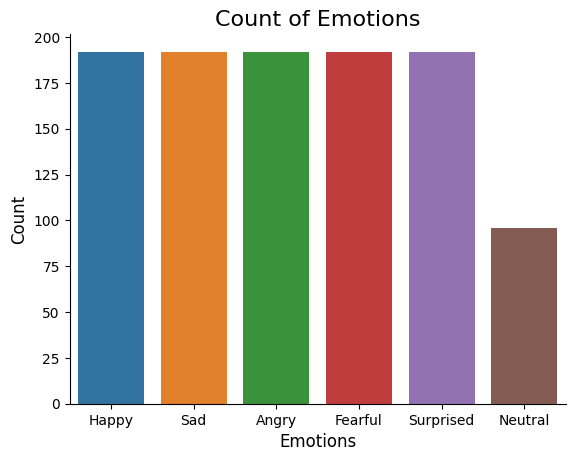

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=df_eda, x='label_name')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [ ]:
print(df_eda['label_name'].value_counts())

Happy        192
Sad          192
Angry        192
Fearful      192
Surprised    192
Neutral       96
Name: label_name, dtype: int64


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
df_eda.head(3)

,speech,emotion,label_name,label
0,/content/drive/MyDrive/ds_dataset/03-01-03-02-...,03-01-03-02-02-01-08,Happy,1
3,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-02-01-08,Happy,1
4,/content/drive/MyDrive/ds_dataset/03-01-04-02-...,03-01-04-02-01-01-08,Sad,0


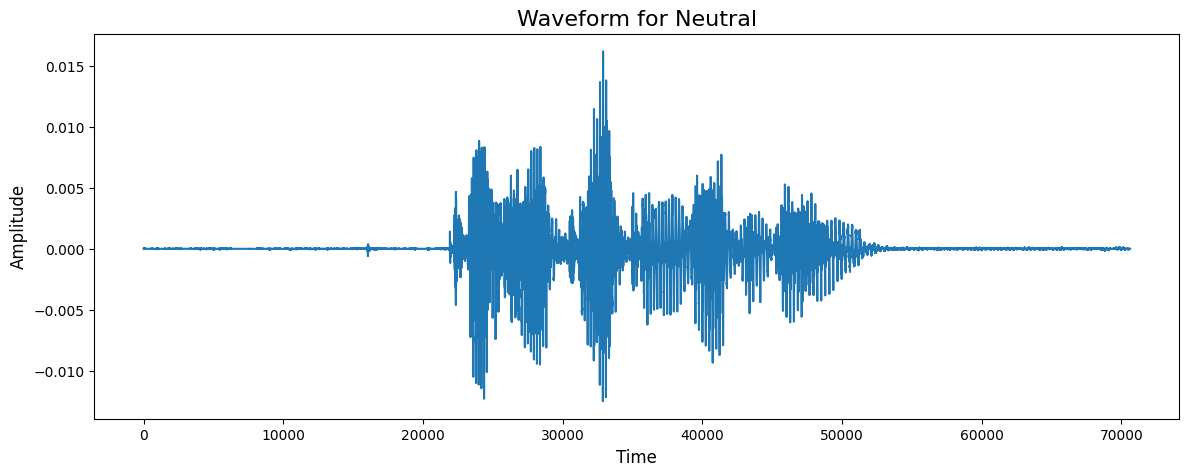

In [ ]:

from IPython.display import Audio

emotion = 'Neutral'
path = np.array(df_eda.speech[df_eda.label_name == emotion])[1]
data, sampling_rate = librosa.load(path)

plt.figure(figsize=(14, 5))
plt.plot(data)
plt.title('Waveform for {}'.format(emotion), size=16)
plt.xlabel('Time', size=12)
plt.ylabel('Amplitude', size=12)
plt.show()

Audio(data, rate=sampling_rate)


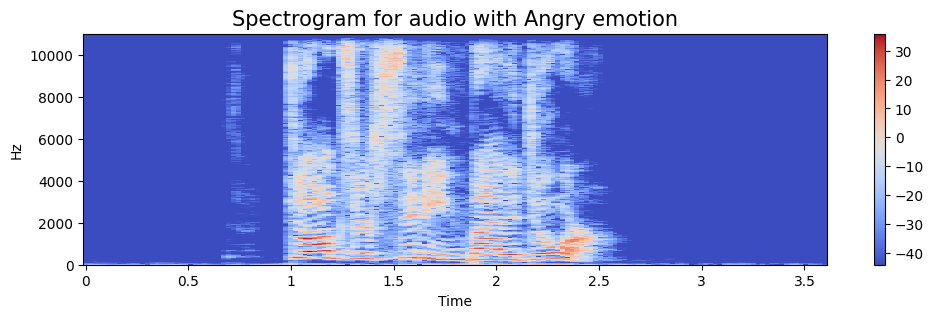

In [ ]:
emotion='Angry'
path = np.array(df_eda.speech[df_eda.label_name==emotion])[1]
data, sampling_rate = librosa.load(path)
# create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
# Audio(path)

In [ ]:
df['label'] = df['label_name'].map({'Sad' : int(0), 'Happy' : int(1), 'Angry' : int(2), 'Fearful' : int(3), 'Surprised' : int(4), 'Calm' : int(5)})

In [ ]:
df

,speech,emotion,label_name,label
0,/content/drive/MyDrive/ds_dataset/03-01-03-02-...,03-01-03-02-02-01-08,Happy,1
1,/content/drive/MyDrive/ds_dataset/03-01-02-01-...,03-01-02-01-02-02-08,Calm,5
2,/content/drive/MyDrive/ds_dataset/03-01-02-02-...,03-01-02-02-01-02-08,Calm,5
3,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-02-01-08,Happy,1
4,/content/drive/MyDrive/ds_dataset/03-01-04-02-...,03-01-04-02-01-01-08,Sad,0
...,...,...,...,...
1435,/content/drive/MyDrive/ds_dataset/03-01-02-01-...,03-01-02-01-01-01-08,Calm,5
1436,/content/drive/MyDrive/ds_dataset/03-01-03-01-...,03-01-03-01-01-02-08,Happy,1
1437,/content/drive/MyDrive/ds_dataset/03-01-02-02-...,03-01-02-02-02-01-08,Calm,5
1438,/content/drive/MyDrive/ds_dataset/03-01-04-01-...,03-01-04-01-02-02-08,Sad,0


In [ ]:
y = pd.get_dummies(df['label']).values
y

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
# print(len(df['labels']))

1248


In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# y_ = enc.fit_transform([df['label']])
# y_.toarray()

array([[1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
# y.categories()

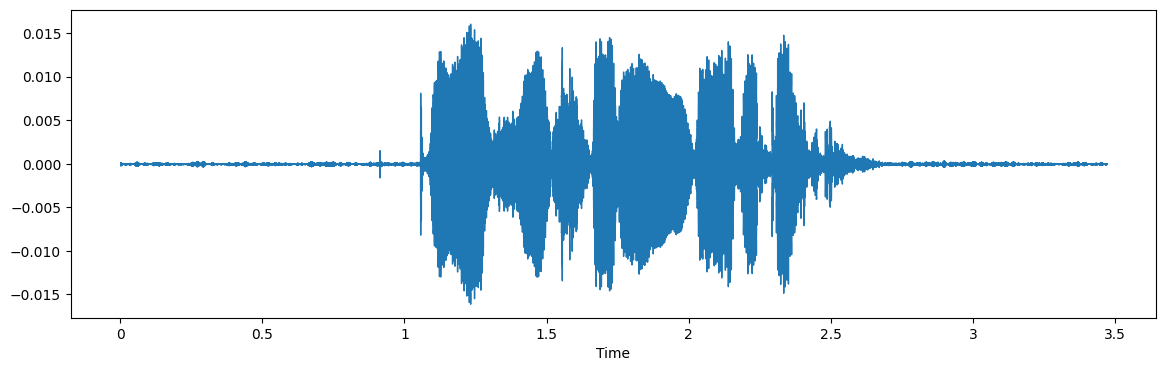

In [ ]:
# plt.figure(figsize=(14,4))
# librosa.display.waveshow(y=data, sr=sample_rate)
# Audio(path)

In [ ]:
def extract_mfcc(filename, max_length=100):
    print(filename)
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=15,n_fft=2048, hop_length=512).T, axis=0)
    return mfcc

In [ ]:
audio_file = df['speech'][0]

In [ ]:
audio_mfcc = extract_mfcc(audio_file)

/content/drive/MyDrive/ds_dataset/03-01-03-02-02-01-08.wav


In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

/content/drive/MyDrive/ds_dataset/03-01-03-02-02-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-02-01-02-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-02-02-01-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-03-01-02-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-04-02-01-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-04-02-02-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-05-01-02-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-02-01-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-01-01-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-04-02-02-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-02-01-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-02-02-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-05-02-02-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-05-02-01-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-05-01-01-01-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-01-02-02-08.wav
/content/drive/MyDrive/ds_dataset/03-01-06-01-01-01-08.w

In [ ]:
X_mfcc = np.array(X_mfcc.tolist())
print(X_mfcc.shape)  

(1152, 15)


In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(1056, 15)

In [ ]:
def extract_zcr(filename):
  y,sr = librosa.load(filename, duration = 3, offset = 0.5)
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=y).T, axis=0)
  return zcr

In [ ]:
audio_zcr = extract_zcr(audio_file)

In [ ]:
X_zcr = df['speech'].apply(lambda x: extract_zcr(x))

In [ ]:
X_zcr = np.array(X_zcr.tolist())
print(X_zcr.shape)  

(1152, 1)


In [ ]:
def extract_rms(filename):
  y,sr= librosa.load(filename, duration = 3,offset = 0.5)
  rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
  return rms

In [ ]:
audio_rms = extract_rms(audio_file)

In [ ]:
X_rms = df['speech'].apply(lambda x: extract_rms(x))

In [ ]:
X_rms = np.array(X_rms.tolist())
print(X_rms.shape)  

(1152, 1)


In [ ]:
def extract_mell(filename):
  y,sr = librosa.load(filename , duration= 3, offset =0.5)
  mel = np.mean(librosa.feature.melspectrogram(y= y , sr=sr).T, axis=0)
  return mel

In [ ]:
audio_mel = (extract_mell(audio_file))
audio_mel.shape

(128,)

In [ ]:
audio_features = np.hstack((audio_mfcc, audio_zcr, audio_rms, audio_mel))
audio_features.shape

(145,)

In [ ]:
X_mel = df['speech'].apply(lambda x: extract_mell(x))

In [ ]:
X_mel.values[0].shape

(128,)

In [ ]:
X_mel = np.array(X_mel.tolist())
print(X_mel.shape)  

(1152, 128)


In [ ]:
all_features = np.hstack((X_mfcc, X_zcr, X_rms, X_mel))
all_features.shape

(1152, 145)

In [ ]:
print(all_features[0].shape)

(145,)


In [ ]:
req_features= np.hstack((X_mfcc,X_zcr , X_rms))

In [ ]:
new_req_features = np.hstack((X_zcr,X_rms ))
new_correct_final = pd.DataFrame(new_req_features)

In [ ]:
mel_df = pd.DataFrame(X_mel)
mel_df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.002614,0.000083,0.000014,0.000014,0.000040,0.004722,0.014272,0.131395,0.380325,1.526976,...,0.000510,0.000326,0.000342,0.000410,0.000740,0.001619,0.002915,0.003327,0.001659,1.562943e-04
1,0.000103,0.000050,0.000047,0.000039,0.000007,0.000376,0.017470,0.076537,0.027274,0.001920,...,0.000005,0.000005,0.000019,0.000043,0.000031,0.000008,0.000007,0.000015,0.000012,1.252203e-06
2,0.000083,0.000026,0.000017,0.000017,0.000026,0.002294,0.024392,0.040233,0.031308,0.004740,...,0.000003,0.000007,0.000025,0.000013,0.000007,0.000006,0.000006,0.000010,0.000006,5.477067e-07
3,0.000098,0.000031,0.000096,0.000182,0.000381,0.008650,0.044203,0.148118,0.237590,0.045060,...,0.000214,0.000172,0.000172,0.000109,0.000119,0.000112,0.000244,0.000237,0.000120,4.827481e-06
4,0.000201,0.000090,0.000057,0.000067,0.000049,0.000053,0.000872,0.024440,0.134827,0.470246,...,0.000010,0.000006,0.000011,0.000018,0.000012,0.000008,0.000023,0.000024,0.000010,8.840303e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.000119,0.000048,0.000011,0.000096,0.000404,0.004502,0.030285,0.035844,0.024947,0.011151,...,0.000001,0.000003,0.000011,0.000015,0.000004,0.000005,0.000004,0.000006,0.000008,5.218978e-07
1148,0.000176,0.000034,0.000075,0.000064,0.000197,0.014139,0.054672,0.145412,0.122779,0.065296,...,0.000013,0.000011,0.000017,0.000016,0.000019,0.000017,0.000029,0.000051,0.000035,1.627144e-06
1149,0.000075,0.000033,0.000022,0.000020,0.000085,0.000836,0.021772,0.055078,0.041716,0.004826,...,0.000024,0.000033,0.000082,0.000106,0.000063,0.000029,0.000024,0.000023,0.000011,9.224750e-07
1150,0.000135,0.000069,0.000031,0.000017,0.000027,0.000126,0.013637,0.060253,0.018633,0.002419,...,0.000012,0.000016,0.000017,0.000024,0.000026,0.000016,0.000014,0.000010,0.000006,6.472095e-07


In [ ]:
correct_df = pd.DataFrame(req_features)
print(correct_df.head(3))

           0          1          2          3         4          5         6   \
0 -479.763336  51.792194 -27.373737  12.413802  2.507613 -15.138287 -4.111307   
1 -692.345154  73.853600  11.183147  22.484844  9.663150   3.359681  3.641027   
2 -673.333984  74.062248  10.070873  19.803295  4.172618   2.558521  6.057234   

          7         8         9          10         11        12        13  \
0 -16.546436 -5.805637 -7.830743 -12.044786  -4.939506 -7.853512 -2.655849   
1 -11.183654 -2.138980 -3.112401   0.355251  -7.436627  1.151342 -0.216681   
2  -9.015502 -2.326800 -3.837869  -1.576903 -10.809388 -2.610172 -4.335229   

         14        15        16  
0 -4.742521  0.161997  0.014533  
1 -2.776512  0.150108  0.002049  
2 -1.162542  0.163612  0.001836  


pca on mel

In [ ]:
new_df = pd.DataFrame(all_features)
# new_df.head()
# new_df['zcr']= X_zcr
# new_df['rms'] = X_rms
# new_df['mel'] = X_mel
# new_df['label']=df['label']
new_df

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,...,0.000510,0.000326,0.000342,0.000410,0.000740,0.001619,0.002915,0.003327,0.001659,1.562943e-04
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,...,0.000005,0.000005,0.000019,0.000043,0.000031,0.000008,0.000007,0.000015,0.000012,1.252203e-06
2,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,...,0.000003,0.000007,0.000025,0.000013,0.000007,0.000006,0.000006,0.000010,0.000006,5.477067e-07
3,-627.019836,65.743149,-1.984382,19.168814,8.411998,-4.089351,-0.652489,-10.962898,-0.953377,-3.926661,...,0.000214,0.000172,0.000172,0.000109,0.000119,0.000112,0.000244,0.000237,0.000120,4.827481e-06
4,-611.721741,69.032394,-7.955007,16.027355,8.655052,-7.593324,-5.145872,-20.467379,-4.566681,1.402165,...,0.000010,0.000006,0.000011,0.000018,0.000012,0.000008,0.000023,0.000024,0.000010,8.840303e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,-673.484985,78.985306,9.472679,20.932680,6.785698,0.310028,4.021769,-11.046672,-2.580672,-3.761756,...,0.000001,0.000003,0.000011,0.000015,0.000004,0.000005,0.000004,0.000006,0.000008,5.218978e-07
1148,-607.591675,61.154602,-11.845318,22.319328,4.487621,-5.201904,-0.349164,-8.826373,-0.999149,-2.382788,...,0.000013,0.000011,0.000017,0.000016,0.000019,0.000017,0.000029,0.000051,0.000035,1.627144e-06
1149,-677.565613,69.741425,15.144119,19.460772,5.905962,6.222984,5.044274,-7.407664,-4.059206,-2.730590,...,0.000024,0.000033,0.000082,0.000106,0.000063,0.000029,0.000024,0.000023,0.000011,9.224750e-07
1150,-694.996521,76.103989,11.912189,17.987270,10.349315,4.824117,-1.749052,-12.369832,-4.407050,0.796404,...,0.000012,0.000016,0.000017,0.000024,0.000026,0.000016,0.000014,0.000010,0.000006,6.472095e-07


In [ ]:
from sklearn.decomposition import PCA
num_components = 1
pca = PCA(n_components= num_components)
sel_df = mel_df[:]
# sel_df2 = new_df[rms_mel]
pca_result = pca.fit_transform(sel_df)
# pca_result_2 = pca.fit_transform(sel_df2)


pc_columns = [f'PC{i+1}' for i in range(num_components)]  
df_pca = pd.DataFrame(data=pca_result, columns=pc_columns)
# df_pca2 = pd.DataFrame(data = pca_result_2 , columns = ['rms_mel'])
# df_final = pd.concat([new_df, df_pca, df_pca2], axis=1)
df_f = pd.concat([ df_pca, correct_df], axis=1)


# print(df_final.head())
print(df_f.head())

        PC1           0          1          2          3         4          5  \
0 -3.930421 -479.763336  51.792194 -27.373737  12.413802  2.507613 -15.138287   
1 -4.610012 -627.019836  65.743149  -1.984382  19.168814  8.411998  -4.089351   
2 -4.687634 -611.721741  69.032394  -7.955007  16.027355  8.655052  -7.593324   
3 -4.674688 -598.691101  74.783493  -4.429770  14.383627  7.122915  -2.979852   
4 -4.338112 -575.354431  53.248596   8.702642  11.945251 -1.799371  -1.607399   

          6          7         8         9         10        11        12  \
0 -4.111307 -16.546436 -5.805637 -7.830743 -12.044786 -4.939506 -7.853512   
1 -0.652489 -10.962898 -0.953377 -3.926661  -3.228476 -4.353993 -3.775071   
2 -5.145872 -20.467379 -4.566681  1.402165  -8.784488 -6.514793 -3.174536   
3 -4.743511 -26.518488 -9.633853  6.562957 -10.090128 -6.439777 -2.022835   
4  7.775626  -8.682298 -5.601964 -5.239933  -3.125750 -3.579266 -2.134408   

         13        14        15        16  
0 -2.6

In [ ]:
df_pca.head(3)

,PC1
0,-3.229907
1,-4.027082
2,-4.034732


In [ ]:
new_correct_df = pd.concat([df_pca, correct_df], axis=1)

In [ ]:
new_correct_df.head(3)

,PC1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-3.229964,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,-12.044786,-4.939506,-7.853512,-2.655849,-4.742521,0.161997,0.014533
1,-4.027082,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,0.355251,-7.436627,1.151342,-0.216681,-2.776512,0.150108,0.002049
2,-4.034731,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,-1.576903,-10.809388,-2.610172,-4.335229,-1.162542,0.163612,0.001836


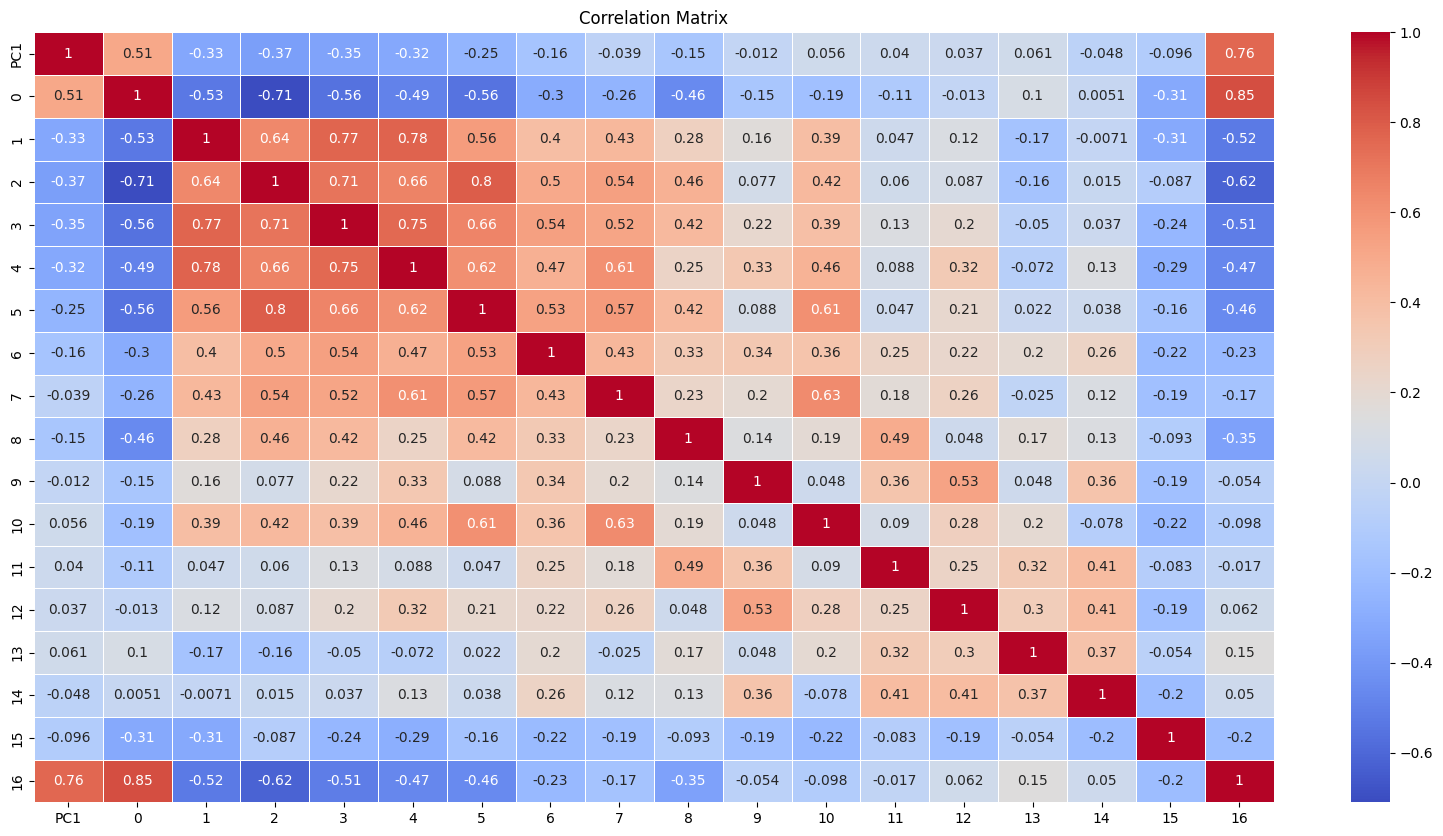

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df and contains the 18 features as columns

# Compute the correlation matrix
correlation_matrix = new_correct_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

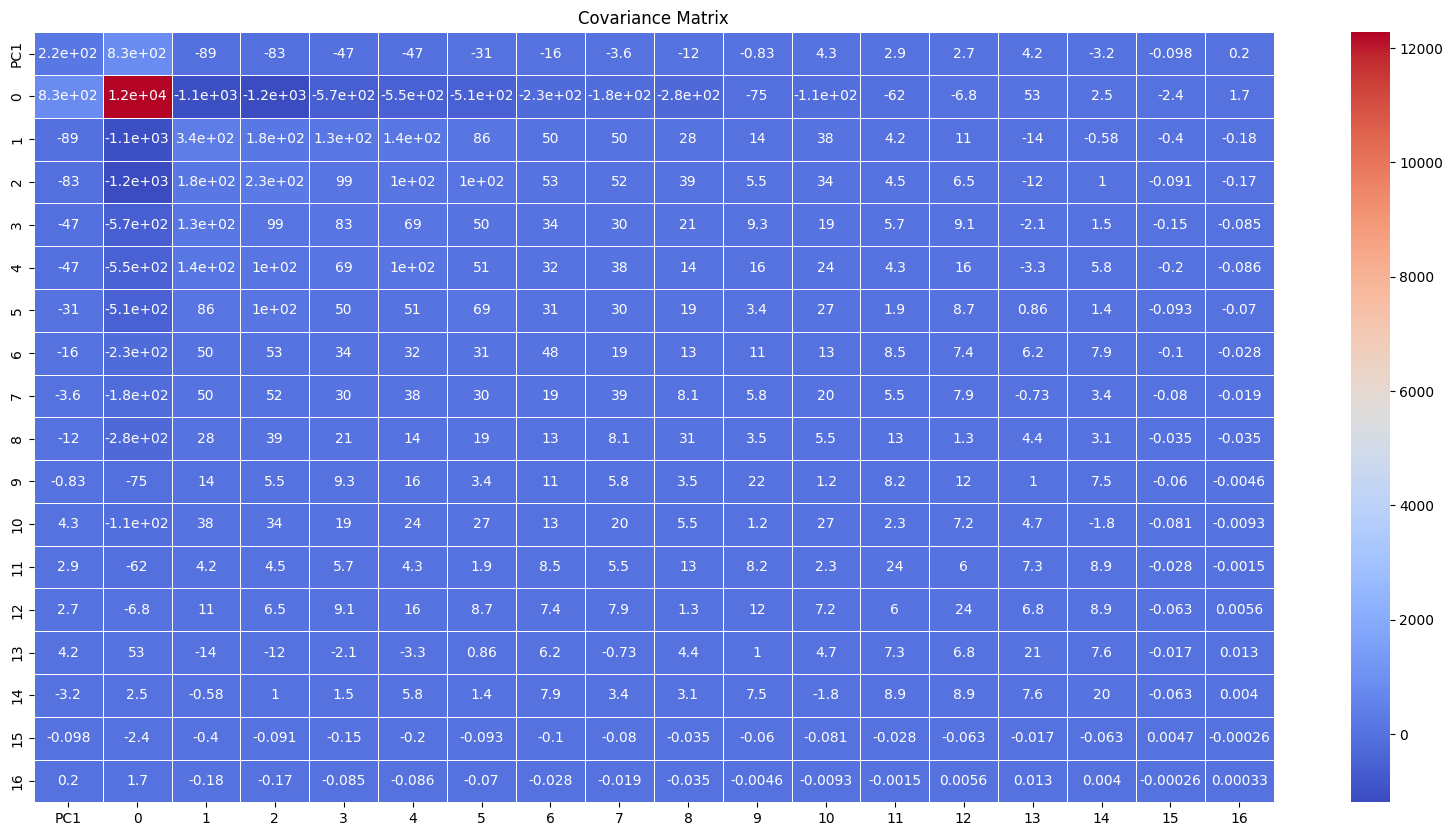

In [ ]:
covar_matrix = new_correct_df.cov()
# print(covar_matrix)
plt.figure(figsize=(20, 10))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix")
plt.show()

In [ ]:
col = {}
for i in range(15):
  col[i] = f'mfcc_{i+1}'
new_df.rename(columns= col , inplace=True)
new_df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,135,136,137,138,139,140,141,142,143,144
0,-479.763336,51.792194,-27.373737,12.413802,2.507613,-15.138287,-4.111307,-16.546436,-5.805637,-7.830743,...,0.000510,0.000326,0.000342,0.000410,0.000740,0.001619,0.002915,0.003327,0.001659,1.562943e-04
1,-692.345154,73.853600,11.183147,22.484844,9.663150,3.359681,3.641027,-11.183654,-2.138980,-3.112401,...,0.000005,0.000005,0.000019,0.000043,0.000031,0.000008,0.000007,0.000015,0.000012,1.252203e-06
2,-673.333984,74.062248,10.070873,19.803295,4.172618,2.558521,6.057234,-9.015502,-2.326800,-3.837869,...,0.000003,0.000007,0.000025,0.000013,0.000007,0.000006,0.000006,0.000010,0.000006,5.477067e-07
3,-627.019836,65.743149,-1.984382,19.168814,8.411998,-4.089351,-0.652489,-10.962898,-0.953377,-3.926661,...,0.000214,0.000172,0.000172,0.000109,0.000119,0.000112,0.000244,0.000237,0.000120,4.827481e-06
4,-611.721741,69.032394,-7.955007,16.027355,8.655052,-7.593324,-5.145872,-20.467379,-4.566681,1.402165,...,0.000010,0.000006,0.000011,0.000018,0.000012,0.000008,0.000023,0.000024,0.000010,8.840303e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,-673.484985,78.985306,9.472679,20.932680,6.785698,0.310028,4.021769,-11.046672,-2.580672,-3.761756,...,0.000001,0.000003,0.000011,0.000015,0.000004,0.000005,0.000004,0.000006,0.000008,5.218978e-07
1244,-607.591675,61.154602,-11.845318,22.319328,4.487621,-5.201904,-0.349164,-8.826373,-0.999149,-2.382788,...,0.000013,0.000011,0.000017,0.000016,0.000019,0.000017,0.000029,0.000051,0.000035,1.627144e-06
1245,-677.565613,69.741425,15.144119,19.460772,5.905962,6.222984,5.044274,-7.407664,-4.059206,-2.730590,...,0.000024,0.000033,0.000082,0.000106,0.000063,0.000029,0.000024,0.000023,0.000011,9.224750e-07
1246,-694.996521,76.103989,11.912189,17.987270,10.349315,4.824117,-1.749052,-12.369832,-4.407050,0.796404,...,0.000012,0.000016,0.000017,0.000024,0.000026,0.000016,0.000014,0.000010,0.000006,6.472095e-07


In [ ]:
cols= new_df.keys()
type(cols)
cols = list(cols)
req_cols = cols[:15]
req_cols

['mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'mfcc_14',
 'mfcc_15']

In [ ]:
from sklearn.decomposition import PCA
num_components = 1
pca = PCA(n_components= num_components)
sel_df = new_df[req_cols]
# sel_df2 = new_df[rms_mel]
pca_result = pca.fit_transform(sel_df)
# pca_result_2 = pca.fit_transform(sel_df2)


pc_columns = [f'PC{i+1}' for i in range(num_components)]  
df_pca2 = pd.DataFrame(data=pca_result, columns=pc_columns)
# df_pca2 = pd.DataFrame(data = pca_result_2 , columns = ['rms_mel'])
# df_final = pd.concat([new_df, df_pca, df_pca2], axis=1)
# df_f = pd.concat([ , df_pca2], axis=1)


# print(df_final.head())
print(df_pca2.head())

          PC1
0   68.754188
1 -148.938834
2 -129.718752
3  -81.802634
4  -65.790577


In [ ]:
new_correct_final.head()

,0,1
0,0.161997,0.014533
1,0.150108,0.002049
2,0.163612,0.001836
3,0.173790,0.004441
4,0.136591,0.004072


In [ ]:
# new_new = pd.concat([df_pca, df_pca2, new_correct_final], axis= 1)
# new_new.head()

,PC1,PC1,0,1
0,-3.229964,68.754188,0.161997,0.014533
1,-4.027082,-148.938834,0.150108,0.002049
2,-4.034731,-129.718752,0.163612,0.001836
3,-3.919701,-81.802634,0.173790,0.004441
4,-3.997178,-65.790577,0.136591,0.004072


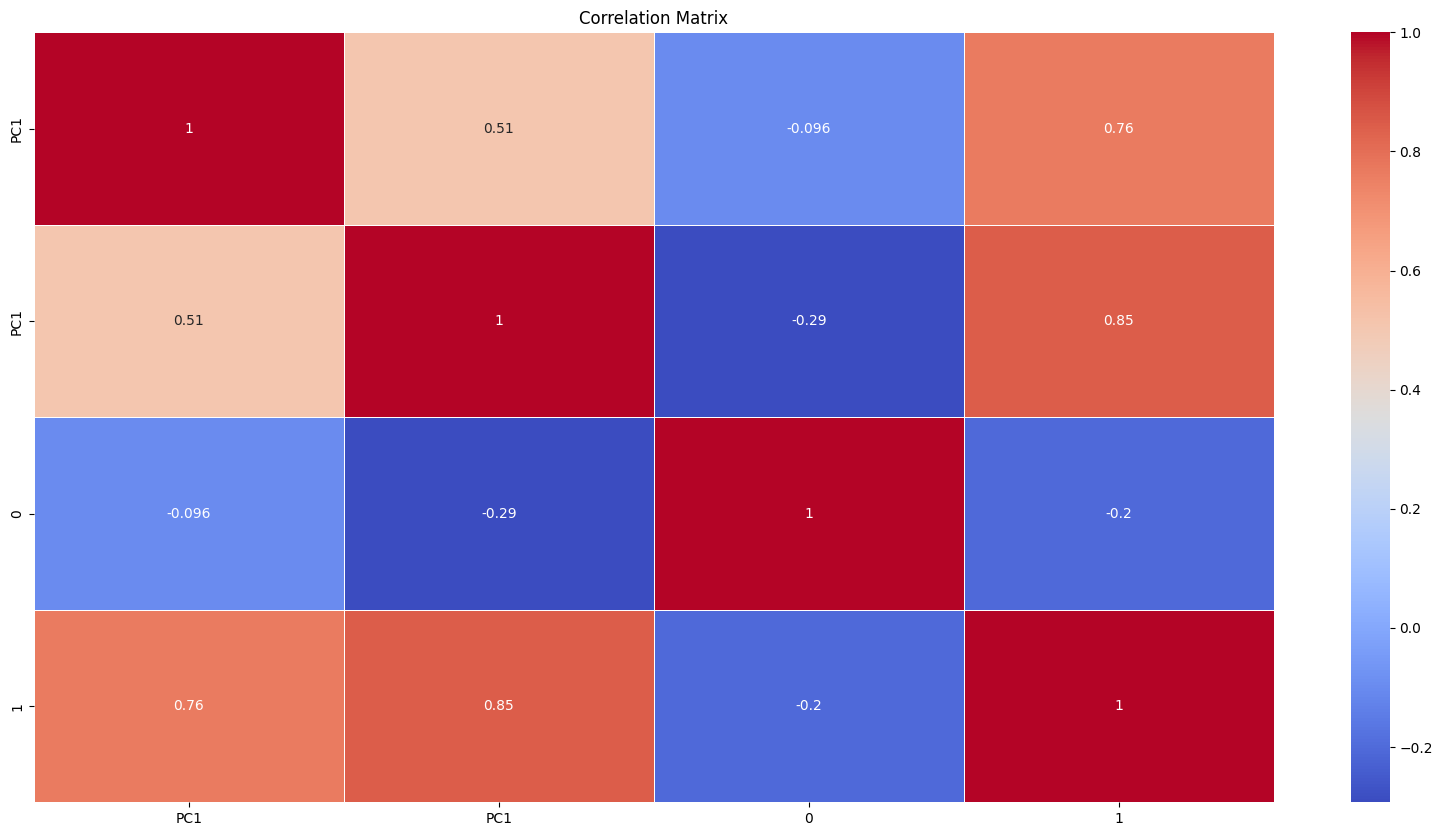

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your dataframe is named df and contains the 18 features as columns

# Compute the correlation matrix
correlation_matrix = new_new.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

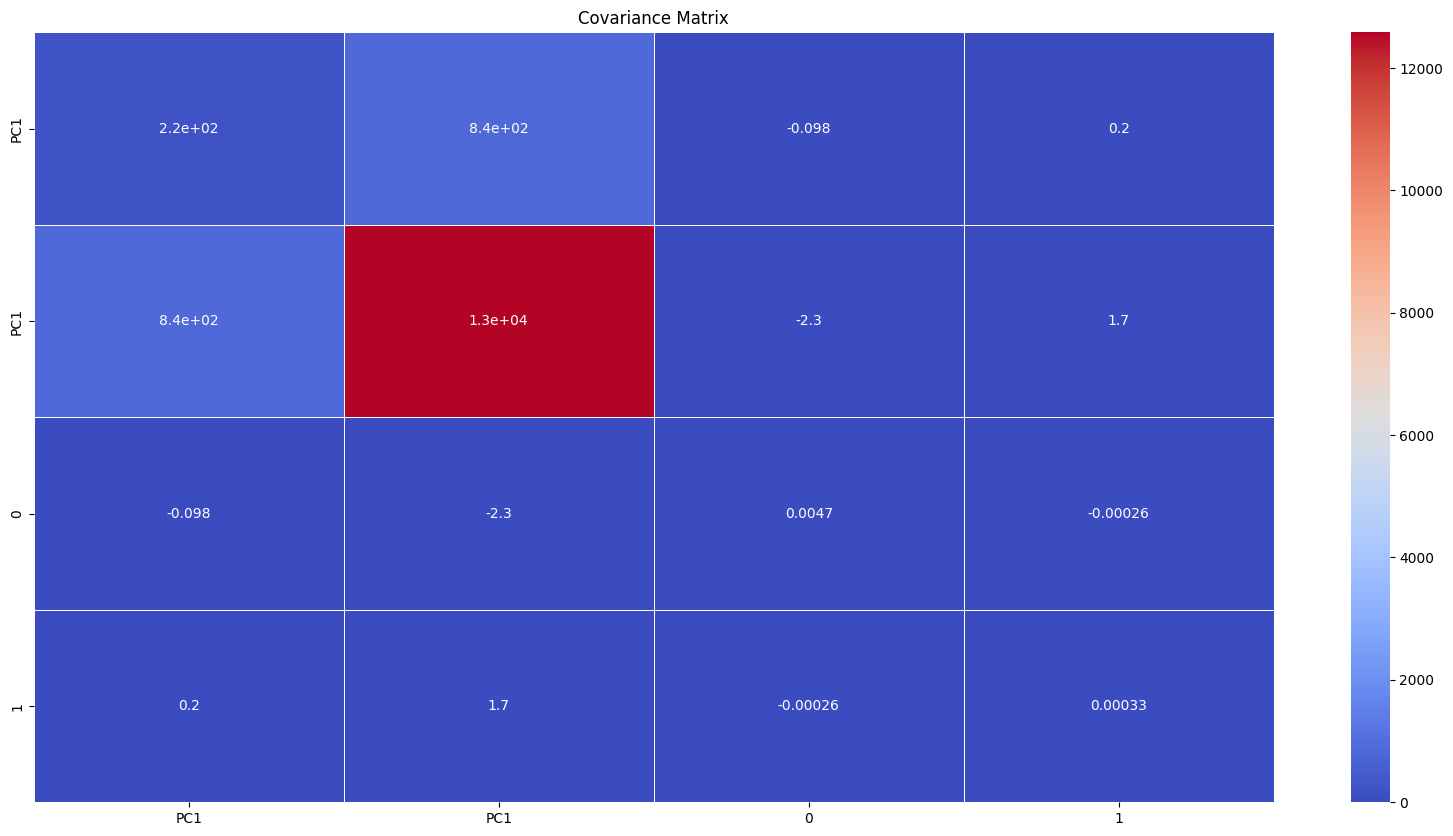

In [ ]:
covar_matrix = new_new.cov()
# print(covar_matrix)
plt.figure(figsize=(20, 10))
sns.heatmap(covar_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Covariance Matrix")
plt.show()

In [ ]:
X_final =new_df.iloc[: ,:].values
X_final.shape

(1152, 145)

In [ ]:
y = pd.get_dummies(df['label']).values
y

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
y.shape

(1152, 6)

In [ ]:
X_zcr.shape

(1152, 1)

In [ ]:
X_F = np.expand_dims(X_final, -1)
X_F.shape, y.shape

((1152, 145, 1), (1152, 6))

In [ ]:
xf = X_F
xf= np.expand_dims(X_F,1)
xf.shape

(1152, 1, 145, 1)

In [ ]:
y

array([[0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       ...,
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_F, y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)
# X_train.tolist()

LSTM MODEL


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming input shape as (1, 145, 1)
input_shape = (145, 1)

# Create the model
cnn_model = Sequential()
cnn_model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Conv1D(64, kernel_size=(3), activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=(2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(6, activation='softmax'))  # Replace num_classes with the actual number of classes

# Compile the cnn_model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the cnn_model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 143, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 71, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 69, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 34, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 2176)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
X_train.shape, Y_train.shape

((806, 145, 1), (806, 6))

In [ ]:
cnn_model.fit(X_train, Y_train, batch_size=32, epochs=150, validation_data=(X_val, Y_val))

Epoch 1/150
26/26 [==============================] - 2s 26ms/step - loss: 2.2720 - accuracy: 0.2630 - val_loss: 1.6693 - val_accuracy: 0.2832
Epoch 2/150
26/26 [==============================] - 0s 16ms/step - loss: 1.6015 - accuracy: 0.3102 - val_loss: 1.6078 - val_accuracy: 0.3410
Epoch 3/150
26/26 [==============================] - 0s 15ms/step - loss: 1.5762 - accuracy: 0.3375 - val_loss: 1.5932 - val_accuracy: 0.3410
Epoch 4/150
26/26 [==============================] - 0s 15ms/step - loss: 1.5270 - accuracy: 0.3536 - val_loss: 1.6018 - val_accuracy: 0.3295
Epoch 5/150
26/26 [==============================] - 0s 17ms/step - loss: 1.5006 - accuracy: 0.3375 - val_loss: 1.6847 - val_accuracy: 0.3121
Epoch 6/150
26/26 [==============================] - 0s 16ms/step - loss: 1.4458 - accuracy: 0.3995 - val_loss: 1.6493 - val_accuracy: 0.3237
Epoch 7/150
26/26 [==============================] - 0s 15ms/step - loss: 1.4153 - accuracy: 0.4082 - val_loss: 1.5801 - val_accuracy: 0.3410
Epoch 

In [ ]:
cnn_model.save('/content/drive/MyDrive/Colab Notebooks/cnn_audio_model.h5')

In [ ]:
y_pred_cnn = cnn_model.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_pred_classes_cnn

6/6 [==============================] - 0s 4ms/step


array([0, 0, 4, 1, 0, 3, 1, 2, 0, 2, 1, 2, 1, 5, 1, 5, 0, 3, 5, 5, 1, 4,
       4, 3, 5, 1, 1, 2, 3, 4, 1, 1, 5, 5, 1, 5, 3, 2, 5, 4, 2, 0, 1, 0,
       1, 0, 2, 0, 1, 3, 3, 1, 5, 1, 5, 5, 1, 3, 0, 3, 4, 0, 5, 2, 3, 5,
       0, 3, 4, 0, 5, 5, 2, 5, 2, 1, 5, 5, 1, 2, 3, 4, 5, 5, 3, 1, 5, 4,
       0, 1, 0, 2, 1, 5, 0, 5, 4, 1, 4, 1, 1, 4, 0, 4, 5, 5, 0, 3, 1, 2,
       0, 5, 3, 0, 3, 0, 2, 0, 3, 3, 0, 1, 5, 0, 4, 1, 5, 0, 1, 1, 3, 0,
       5, 0, 4, 1, 0, 2, 5, 3, 1, 2, 1, 0, 2, 0, 5, 3, 0, 2, 3, 3, 4, 5,
       4, 4, 5, 5, 5, 4, 0, 5, 4, 0, 2, 1, 5, 1, 5, 4, 3, 2, 1])

In [ ]:
y_test = np.argmax(Y_test, axis=1)
y_test

array([4, 0, 1, 1, 5, 0, 2, 2, 2, 3, 3, 4, 3, 5, 1, 5, 0, 3, 5, 5, 1, 4,
       4, 3, 2, 2, 0, 2, 3, 4, 1, 1, 5, 5, 1, 5, 3, 0, 0, 4, 2, 3, 3, 0,
       1, 5, 3, 0, 2, 3, 1, 1, 0, 2, 5, 5, 4, 3, 0, 5, 4, 0, 5, 2, 4, 5,
       4, 1, 4, 0, 5, 0, 2, 5, 1, 4, 5, 5, 1, 2, 3, 4, 0, 5, 2, 1, 5, 4,
       3, 1, 0, 2, 1, 5, 0, 5, 3, 1, 4, 1, 1, 4, 3, 1, 5, 0, 1, 3, 1, 2,
       0, 5, 4, 5, 3, 0, 2, 2, 3, 3, 5, 1, 5, 0, 4, 1, 5, 0, 2, 1, 4, 0,
       5, 0, 0, 1, 3, 4, 5, 1, 1, 2, 1, 5, 2, 3, 5, 3, 5, 2, 3, 3, 4, 5,
       4, 3, 1, 5, 1, 4, 5, 5, 4, 0, 2, 4, 5, 4, 5, 4, 3, 2, 3])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_pred_classes_cnn, y_test)
cm = confusion_matrix(y_pred_classes_cnn, y_test)
print(cm)
print(cr)

[[16  1  2  5  2  7]
 [ 1 22  5  4  4  0]
 [ 1  1 14  2  2  0]
 [ 1  3  1 15  3  1]
 [ 1  2  0  2 16  0]
 [ 5  2  1  0  0 31]]
              precision    recall  f1-score   support

           0       0.64      0.48      0.55        33
           1       0.71      0.61      0.66        36
           2       0.61      0.70      0.65        20
           3       0.54      0.62      0.58        24
           4       0.59      0.76      0.67        21
           5       0.79      0.79      0.79        39

    accuracy                           0.66       173
   macro avg       0.65      0.66      0.65       173
weighted avg       0.67      0.66      0.66       173



LSTM MODEL

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, RNN
import tensorflow as tf
import tensorflow as tf

model = Sequential()
model.add(Bidirectional(LSTM(256, input_shape=(145, 1))))
model.add(Dropout(0.3))
# model.add(Dense(30, input_shape=(18, ), activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))


In [ ]:
Y_train

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
# X_train = np.transpose(X_train, (0, 2, 1))
# X_train.shape
# # X_val = tf.sparse.to_dense(X_val)
model.summary()

In [ ]:
xtrain = X_train.tolist()
len(xtrain[0])

145

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=64, verbose=1)

# # evaluate the model
# loss, accuracy = model.evaluate(X_val, Y_val)

Epoch 1/100
12/12 [==============================] - 12s 111ms/step - loss: 1.8274 - accuracy: 0.2016 - val_loss: 1.7012 - val_accuracy: 0.2390
Epoch 2/100
12/12 [==============================] - 0s 25ms/step - loss: 1.6884 - accuracy: 0.3045 - val_loss: 1.6422 - val_accuracy: 0.3270
Epoch 3/100
12/12 [==============================] - 0s 25ms/step - loss: 1.6882 - accuracy: 0.2747 - val_loss: 1.6251 - val_accuracy: 0.3270
Epoch 4/100
12/12 [==============================] - 0s 25ms/step - loss: 1.6433 - accuracy: 0.2991 - val_loss: 1.5748 - val_accuracy: 0.3208
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 1.6140 - accuracy: 0.3085 - val_loss: 1.5893 - val_accuracy: 0.3774
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 1.5831 - accuracy: 0.3396 - val_loss: 1.5697 - val_accuracy: 0.3396
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 1.5713 - accuracy: 0.3518 - val_loss: 1.5331 - val_accuracy: 0.3711
Epoc

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes

5/5 [==============================] - 1s 11ms/step


array([4, 2, 3, 0, 1, 4, 2, 0, 1, 4, 2, 5, 4, 3, 0, 0, 3, 2, 5, 4, 2, 2,
       2, 2, 2, 1, 5, 2, 4, 1, 1, 1, 2, 0, 1, 1, 0, 4, 2, 5, 4, 4, 5, 5,
       0, 5, 1, 0, 2, 5, 0, 0, 4, 0, 5, 5, 4, 2, 1, 1, 2, 5, 2, 2, 1, 1,
       0, 2, 2, 0, 1, 0, 3, 5, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 5, 0, 1, 2,
       4, 2, 5, 2, 5, 1, 5, 0, 0, 5, 3, 0, 0, 1, 4, 2, 2, 2, 5, 4, 1, 5,
       4, 2, 3, 1, 5, 4, 2, 5, 1, 3, 1, 4, 3, 3, 2, 5, 1, 3, 4, 3, 4, 3,
       3, 2, 5, 0, 3, 2, 3, 1, 4, 3, 4, 2, 1, 5, 1, 2, 1, 0, 0, 3, 3, 4,
       1, 4, 5, 2])

In [ ]:
y_test = np.argmax(Y_test, axis=1)
y_test

array([4, 3, 1, 1, 1, 4, 4, 0, 1, 2, 0, 4, 1, 4, 0, 1, 3, 2, 4, 4, 2, 2,
       2, 1, 2, 1, 2, 2, 3, 1, 1, 1, 2, 0, 1, 1, 3, 4, 2, 0, 4, 4, 4, 5,
       0, 2, 2, 0, 3, 5, 3, 0, 4, 3, 5, 0, 3, 2, 1, 1, 2, 1, 0, 3, 1, 1,
       0, 2, 1, 0, 1, 0, 1, 5, 4, 0, 4, 0, 2, 3, 0, 1, 1, 0, 0, 0, 1, 1,
       4, 4, 5, 1, 5, 4, 5, 0, 4, 3, 3, 3, 0, 2, 2, 2, 4, 1, 3, 4, 0, 0,
       4, 2, 3, 1, 0, 4, 2, 5, 4, 3, 3, 4, 2, 3, 2, 5, 2, 1, 1, 3, 4, 1,
       1, 4, 1, 0, 3, 4, 0, 1, 4, 3, 4, 0, 1, 5, 3, 2, 1, 0, 5, 3, 3, 4,
       1, 2, 5, 4])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cr = classification_report(y_pred_classes, y_test)
cm = confusion_matrix(y_pred_classes, y_test)
print(cm)
print(cr)

[[18  2  0  5  2  1]
 [ 1 21  3  2  2  0]
 [ 3  5 17  3  7  0]
 [ 1  5  1 10  1  0]
 [ 0  2  3  2 16  0]
 [ 5  2  2  2  3 11]]
              precision    recall  f1-score   support

           0       0.64      0.64      0.64        28
           1       0.57      0.72      0.64        29
           2       0.65      0.49      0.56        35
           3       0.42      0.56      0.48        18
           4       0.52      0.70      0.59        23
           5       0.92      0.44      0.59        25

    accuracy                           0.59       158
   macro avg       0.62      0.59      0.58       158
weighted avg       0.63      0.59      0.59       158



In [ ]:
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score

# model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# model.fit(X_train,Y_train)

# #DataFlair - Predict for the test set
# y_pred=model.predict(X_test)



In [ ]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred_classes)
#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_audio_model.h5')

In [ ]:
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/saved_audio_model.h5')

In [ ]:
audio_features = np.hstack((audio_mfcc, audio_zcr, audio_rms, audio_mel))
audio_features.shape

(145,)

In [ ]:
audio_features = np.expand_dims(audio_features, 0)

In [ ]:
audio_features.shape, X_test[0].shape

((1, 145), (145, 1))

In [ ]:
X_test.shape, audio_features.shape

((158, 145, 1), (1, 145))

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred_new = new_model.predict(np.expand_dims(X_test[0], 0))
print(y_pred_new.shape)
# y_pred_new = [y_pred_new[0]]
y_pred_classes = np.argmax(y_pred_new, axis=1)
y_pred_classes
# cr = classification_report(y_pred_classes, y_test)
# cm = confusion_matrix(y_pred_classes, y_test)
# print(cm)
# print(cr)

In [ ]:
index = np.argmax([y_pred_new[0]], axis=1)
emotion_set = ['sad', 'joy', 'anger', 'fear','surprise', 'neutral']
emotion_set[index[0]]

'sad'

In [ ]:
len(X_test[0])

18

In [ ]:
y_pred_new

array([[5.7459867e-04, 1.8133383e-02, 1.4768256e-03, 2.1385804e-03,
        9.7764027e-01, 3.6386406e-05],
       [1.9868303e-04, 9.9696821e-01, 2.6086855e-05, 5.8677182e-05,
        4.6900595e-06, 2.7436896e-03],
       [1.3667318e-03, 4.6937275e-03, 9.8889315e-05, 2.7360467e-04,
        6.2724220e-04, 9.9293983e-01],
       ...,
       [5.9735077e-04, 9.9638784e-01, 2.2184623e-04, 7.3642220e-04,
        2.0560378e-03, 5.0882005e-07],
       [8.8811088e-05, 1.2081546e-02, 4.9651531e-04, 1.6664505e-02,
        9.7039819e-01, 2.7046943e-04],
       [6.9323978e-05, 2.1259801e-01, 1.0623176e-04, 4.8012516e-06,
        7.8306043e-01, 4.1612205e-03]], dtype=float32)